In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from statsmodels.tsa.api import SimpleExpSmoothing

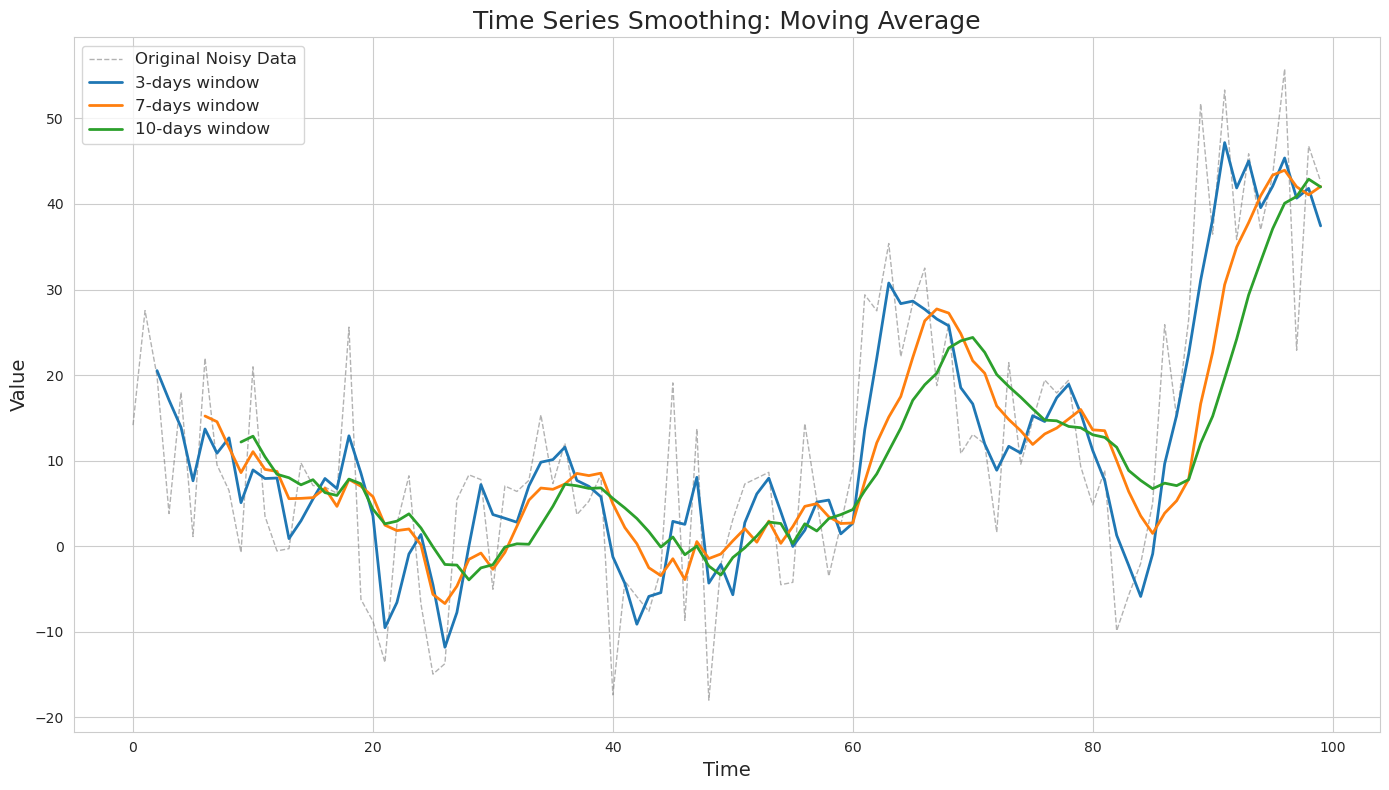

In [59]:
def generate_time_series(
    n_points=100,
    rng_seed=42,
    n_segments=None,
    season_period=30,
    season_amplitude=8.0,
    noise_scale=4.0,
    offset=10.0,
):
    """
    Generates a synthetic time series that sometimes grows, sometimes declines,
    and includes cyclical (seasonal) behavior plus noise.

    Args:
        n_points (int): length of the series.
        rng_seed (int): random seed for reproducibility.
        n_segments (int|None): number of piecewise linear trend segments (random if None).
        season_period (int|float): main seasonal period (in samples).
        season_amplitude (float): base amplitude of the seasonal component.
        noise_scale (float): standard deviation of additive Gaussian noise.
        offset (float): constant offset added to the series.

    Returns:
        pd.Series: synthetic time series indexed by integer time.
    """
    rng = np.random.default_rng(seed=rng_seed)
    time = np.arange(n_points)

    # piecewise linear trend: a few segments with random slopes (can be positive or negative)
    if n_segments is None:
        n_segments = int(rng.integers(3, 6))  # 3..5 segments by default
    # distribute points among segments
    base_len = n_points // n_segments
    lengths = [base_len] * n_segments
    for i in range(n_points - base_len * n_segments):
        lengths[i % n_segments] += 1

    # random slopes (allow negative slopes for decreasing periods)
    slopes = rng.normal(loc=0.15, scale=0.5, size=n_segments)  # tweak mean/scale to taste
    # build trend by integrating slopes over each segment
    trend = np.empty(n_points, dtype=float)
    idx = 0
    current = 0.0
    for seg_i, seg_len in enumerate(lengths):
        s = slopes[seg_i]
        # optionally add a small local curvature inside segment
        local = current + s * np.arange(seg_len) + 0.02 * s * (np.arange(seg_len) ** 1.5)
        trend[idx: idx + seg_len] = local
        current = local[-1] if seg_len > 0 else current
        idx += seg_len

    # seasonal / cyclic behavior: main sinusoid + secondary harmonic, with slow amplitude modulation
    phase = rng.uniform(0, 2 * np.pi)
    seasonal_main = np.sin(2 * np.pi * time / season_period + phase)
    seasonal_harm = 0.4 * np.sin(2 * np.pi * time / (season_period / 2 + 1e-6) + phase * 1.3)
    # slow amplitude modulation to make cycles vary
    amp_mod = 1.0 + 0.5 * np.sin(2 * np.pi * time / (season_period * rng.uniform(3, 6)) + rng.uniform(0, 2 * np.pi))
    seasonal = season_amplitude * amp_mod * (seasonal_main + seasonal_harm)

    # optional occasional bumps (sporadic events)
    bumps = np.zeros(n_points)
    for _ in range(int(n_points / 100) + rng.integers(0, 3)):
        center = rng.integers(0, n_points)
        width = rng.integers(3, max(4, n_points // 40))
        height = rng.normal(loc=0.0, scale=season_amplitude * 0.6)
        span = np.arange(n_points)
        bumps += height * np.exp(-0.5 * ((span - center) / width) ** 2)

    # noise
    noise = rng.normal(loc=0.0, scale=noise_scale, size=n_points)

    series = trend + seasonal + bumps + noise + offset
    return pd.Series(series, index=time)


# Generate the synthetic data
data = generate_time_series(noise_scale=12)

def generate_ma(series: pd.Series, window_size: int) -> pd.Series:
    """
    Applies Moving Average smoothing to the input series.
    
    Args:
        series (pd.Series): The input time series.
        window_size (int): The size of the moving window.
        
    Returns:
        pd.Series: The smoothed time series.
    """
    return series.rolling(window=window_size).mean()


def generate_exponetial_smoothing(series: pd.Series, alpha: float) -> pd.Series:
    """
    Applies Exponential Smoothing to the input series.
    
    Args:
        series (pd.Series): The input time series.
        alpha (float): The smoothing factor (0 < alpha < 1).
        
    Returns:
        pd.Series: The smoothed time series.
    """
    model = SimpleExpSmoothing(series, initialization_method="estimated")
    fit = model.fit(smoothing_level=alpha, optimized=False)
    return fit.fittedvalues


ma_3d = generate_ma(data, window_size=3)
ma_7d = generate_ma(data, window_size=7)
ma_10d = generate_ma(data, window_size=10)
es_02 = generate_exponetial_smoothing(data, alpha=0.2)
es_05 = generate_exponetial_smoothing(data, alpha=0.5)
es_08 = generate_exponetial_smoothing(data, alpha=0.8)

with sns.axes_style("whitegrid"):
    plt.figure(figsize=(14, 8))
    
    # Plot original noisy series
    plt.plot(data, label='Original Noisy Data', color='gray', alpha=0.6, linestyle='--', linewidth=1)
    
    # Plot Moving Average smoothed series
    plt.plot(ma_3d, label='3-days window', lw=2)
    plt.plot(ma_7d, label='7-days window', lw=2)
    plt.plot(ma_10d, label='10-days window', linewidth=2)
    
    # Add plot details
    plt.title('Time Series Smoothing: Moving Average', fontsize=18)
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('Value', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('../../assets/images/time_series/times_series_ma_smoothing.png', bbox_inches='tight')
    
    plt.show()


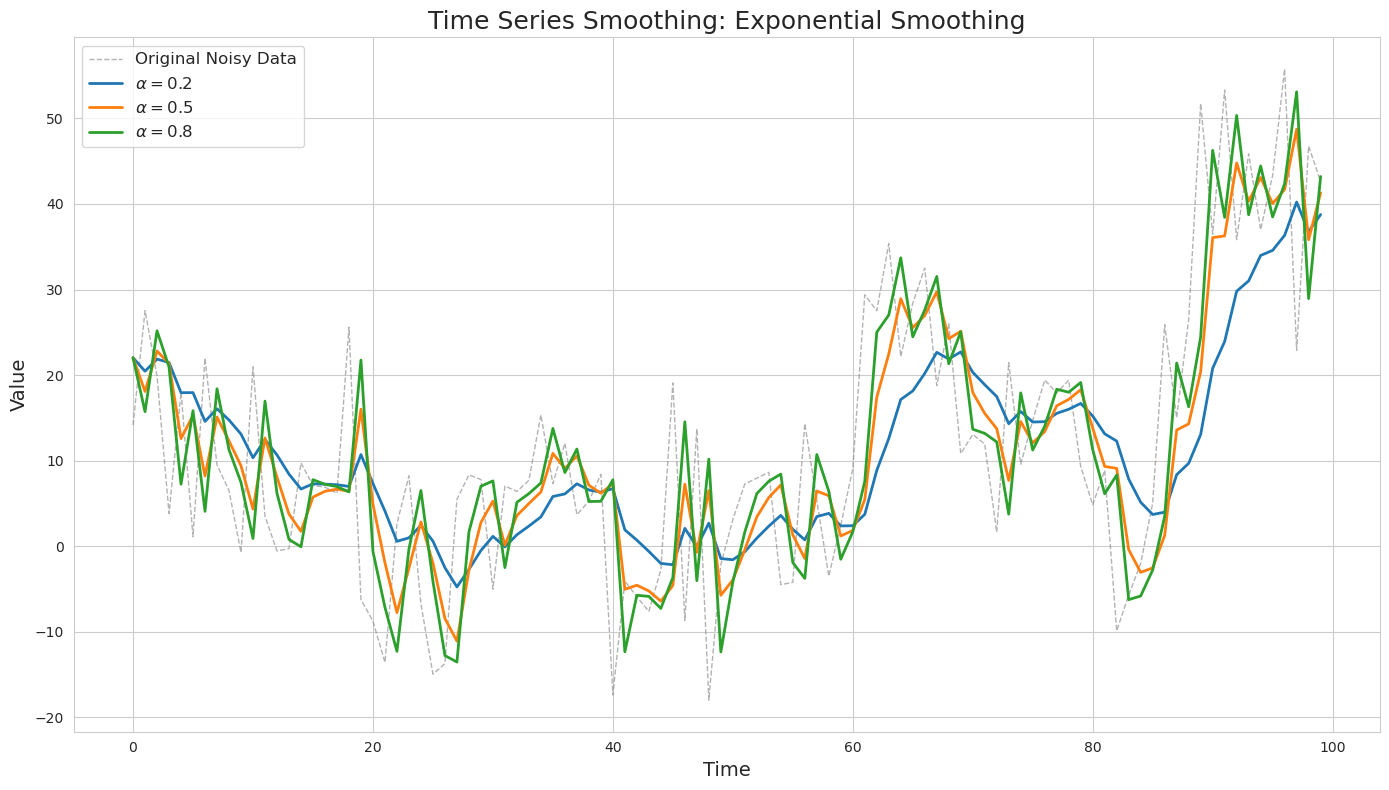

In [20]:
with sns.axes_style("whitegrid"):
    plt.figure(figsize=(14, 8))
    
    # Plot original noisy series
    plt.plot(data, label='Original Noisy Data', color='gray', alpha=0.6, linestyle='--', linewidth=1)
    
    # Plot Exponential Smoothing smoothed series
    plt.plot(es_02, label=r'$\alpha = 0.2$', linewidth=2)
    plt.plot(es_05, label=r'$\alpha = 0.5$', linewidth=2)
    plt.plot(es_08, label=r'$\alpha = 0.8$', linewidth=2)
    
    # Add plot details
    plt.title('Time Series Smoothing: Exponential Smoothing', fontsize=18)
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('Value', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('../../assets/images/time_series/times_series_es_smoothing.png', bbox_inches='tight')
    
    plt.show()

In [21]:
from pykalman.datasets import load_robot
from pykalman import KalmanFilter



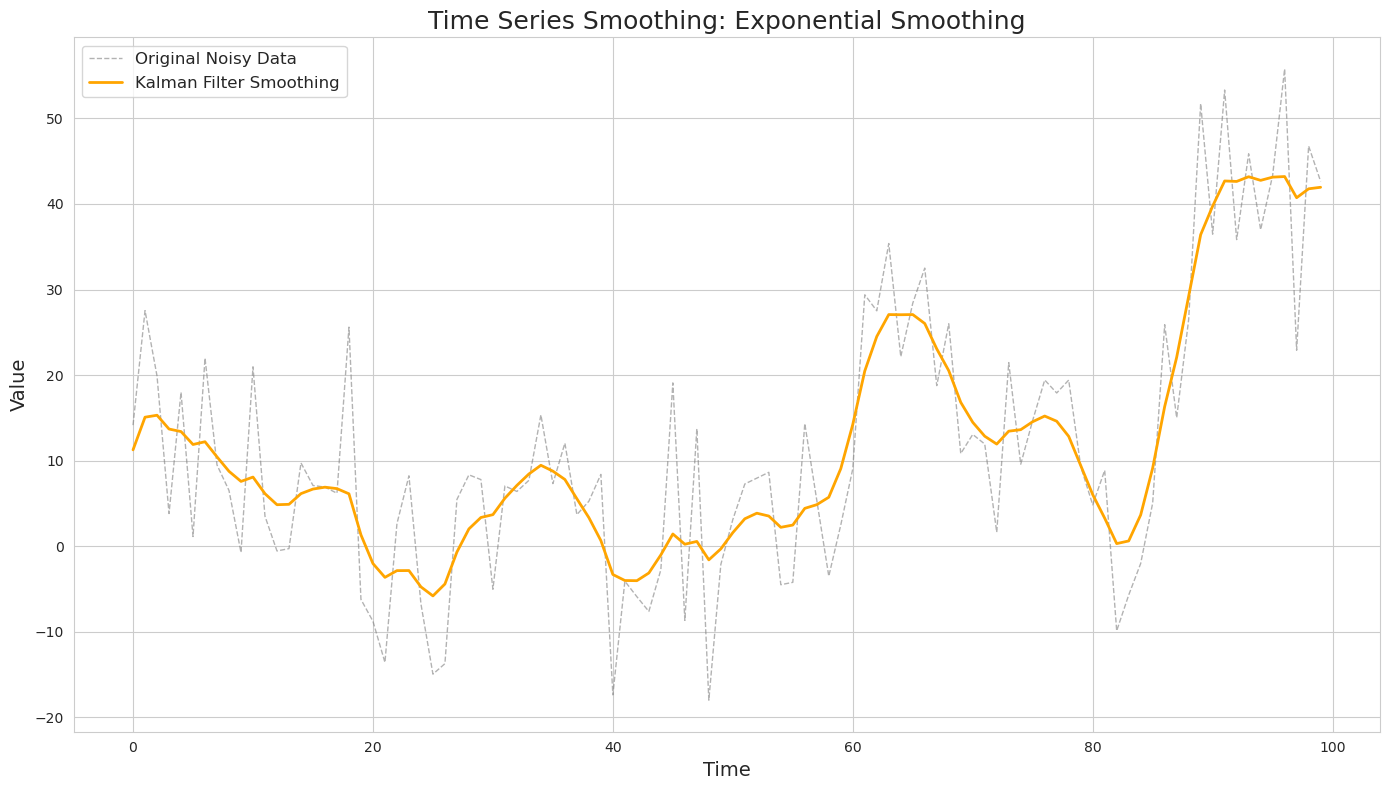

In [65]:
kf = KalmanFilter(
    transition_matrices=np.array([[1, 1], [0, 1]]),
    #transition_covariance=0.01 * np.eye(2),
)

kalman_p_states, kalman_p_cov = kf.em(data).smooth(data)

with sns.axes_style("whitegrid"):
    plt.figure(figsize=(14, 8))
    
    # Plot original noisy series
    plt.plot(data, label='Original Noisy Data', color='gray', alpha=0.6, linestyle='--', linewidth=1)
    
    plt.plot(kalman_p_states[:, 0], label='Kalman Filter Smoothing', color='orange', linewidth=2)
    
    # Add plot details
    plt.title('Time Series Smoothing: Exponential Smoothing', fontsize=18)
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('Value', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('../../assets/images/time_series/times_series_kalman_smoothing.png', bbox_inches='tight')
    
    plt.show()